In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import lightgbm as lgb

import coursera_competition_udfs as udf
import gc
from scipy.stats import percentileofscore
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Build monthly sales grid with lags

- First, we aggregate sales data by month, where for each month we create a grid of all the shops and items that have sales in that month. (Note that all other combinations would yield rows or columns of zeroes, but this introduces survivor bias). We then stack monthly time series data for all such shop-item pairs.
- Then we created lagged sales of the 3 types of sales data: previous monthly sales of the shop_item pair, and previous monthly sales of the shop, and item, for different lag periods
- Finally we merge lagged sales data with other information, such as seasonality features

In [ ]:
# lag_months = [1, 2, 3, 6, 12]
# all_sales = udf.create_all_monthly_sales_grid_with_lags(lags=lag_months)
# all_sales = udf.add_seasonality_features(all_sales)
# all_sales = udf.add_sales_features(all_sales)
# all_sales.to_pickle("./all_sales_lags_1_2_3_6_12_seasonality.pkl")

In [2]:
all_sales = pd.read_pickle("./all_sales_lags_1_2_3_6_12_seasonality.pkl")

In [3]:
all_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488756 to 11128049
Data columns (total 26 columns):
date_block_num             int64
item_id                    category
shop_id                    category
target                     float64
target_lag_1               int64
target_item_lag_1          int64
target_shop_lag_1          int64
target_lag_2               int64
target_item_lag_2          int64
target_shop_lag_2          int64
target_lag_3               int64
target_item_lag_3          int64
target_shop_lag_3          int64
target_lag_6               int64
target_item_lag_6          int64
target_shop_lag_6          int64
target_lag_12              int64
target_item_lag_12         int64
target_shop_lag_12         int64
december                   bool
Q1                         bool
Q4                         bool
target_shop_zero           bool
target_item_zero           bool
target_shop_recent_zero    bool
target_item_recent_zero    bool
dtypes: bool(7), cate

In [5]:
nul_cols = all_sales.isnull().sum()
nul_cols[nul_cols>0]

target    214200
dtype: int64

# Prepare data for model training

## Feature preprocessing for non-tree models
Note that we are processing all labelled data together, rather than separating out a valuation set first. This kind of leakage is ok for now since we will be doing the same for the real test data.

In [6]:
# references to lagged sales columns
lag_cols = [col for col in all_sales.columns if '_lag_' in col]
target_lags = [col for col in all_sales.columns if 'target_lag' in col]
item_lags = [col for col in all_sales.columns if 'target_item_lag' in col]
shop_lags = [col for col in all_sales.columns if 'target_shop_lag' in col]

### Numerical features

In [9]:
sales_num = all_sales.select_dtypes(include=['number', 'bool']).copy()

In [10]:
# training and validation data, with all possible features
X_train_num, X_val_num, y_train, y_val = udf.train_test_split_by_month(sales_num)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]
Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 23


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


In [10]:
# compare target distributions in train and validation data
print('average target in training set:', y_train.mean())
print('average target in validation set:', y_val.mean())

# variation in target variable in train vs val data
best_const_train = [y_train.mean()] * len(y_train)
best_const_val = [y_val.mean()] * len(y_val)

print('Variation of train data (RMSE of best constant on train):',
      np.sqrt(mean_squared_error(y_train, best_const_train)))

print('Variation of val data (RMSE of best constant on val):',
      np.sqrt(mean_squared_error(y_val, best_const_val)))

average target in training set: 0.32559195024601895
average target in validation set: 0.25856523856708596
Variation of train data (RMSE of best constant on train): 3.5316623345135882
Variation of val data (RMSE of best constant on val): 1.136154784234743


#### Nonlinear transformations

In [14]:
# nonlinear transformation of lagged sales
sales_trans = sales_num.copy()
for col in lag_cols:
    sales_trans[col], _ = udf.log_transform(sales_trans[col])

Remarks:
- logging the past sales data makes the target lags slighly less skewed, but not by much
- it helps more with target-item lags
- it's informative for shop lags. in particular, we see a lot of zeroes after this transformation, corresponding to the shop selling at the minimum, which is zero.

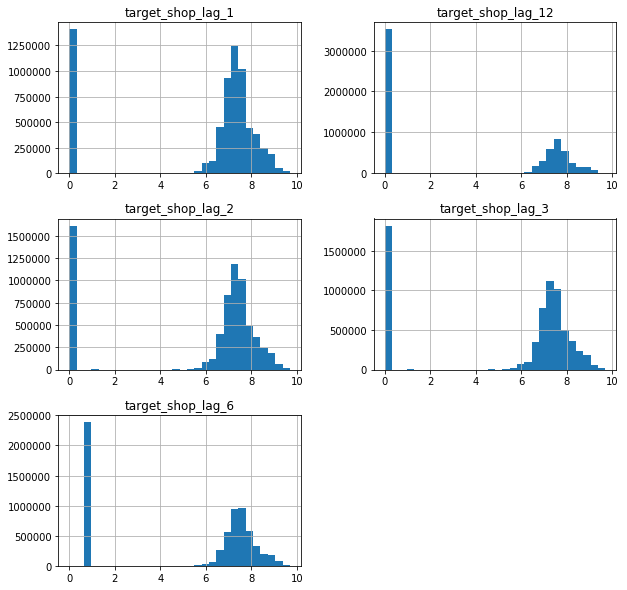

In [15]:
# Distribution of target shop lag after log transformation
sales_trans[shop_lags].hist(figsize=(10,10), bins=30);

In [16]:
# training and validation data, with all possible features
X_train_trans, X_val_trans, y_train, y_val = udf.train_test_split_by_month(sales_trans)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 20


In [17]:
y_train_trans, y_train_min = udf.log_transform(y_train)

#### Winsorizing sales data

In [22]:
sales_wins = sales_num.copy()

In [40]:
sales_wins.shape

(6639294, 23)

In [50]:
sales_wins[target_lags].max()

target_lag_1     25
target_lag_2     25
target_lag_3     25
target_lag_6     25
target_lag_12    25
dtype: int64

In [41]:
sales_wins[target_lags].quantile(0.999)

target_lag_1     21.0
target_lag_2     21.0
target_lag_3     22.0
target_lag_6     22.0
target_lag_12    21.0
Name: 0.999, dtype: float64

In [49]:
sales_wins[shop_lags].max()

target_shop_lag_1     16318
target_shop_lag_2     16318
target_shop_lag_3     16318
target_shop_lag_6     16318
target_shop_lag_12    16318
dtype: int64

In [46]:
sales_wins[shop_lags].quantile(0.999)

target_shop_lag_1     14610.0
target_shop_lag_2     14610.0
target_shop_lag_3     14610.0
target_shop_lag_6     14610.0
target_shop_lag_12    12670.0
Name: 0.999, dtype: float64

In [38]:
sales_wins[item_lags].max()

target_item_lag_1     12557
target_item_lag_2     12557
target_item_lag_3     12557
target_item_lag_6     12557
target_item_lag_12    12557
dtype: int64

In [43]:
sales_wins[item_lags].quantile(0.999)

target_item_lag_1     714.0
target_item_lag_2     728.0
target_item_lag_3     748.0
target_item_lag_6     771.0
target_item_lag_12    718.0
Name: 0.999, dtype: float64

In [48]:
sales_wins[target_lags] = sales_wins[target_lags].clip(upper=25)

In [51]:
# training and validation data, with all possible features
X_train_wins, X_val_wins, y_train, y_val = udf.train_test_split_by_month(sales_wins)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]
Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 20


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


### Feature scaling

In [54]:
sales_std = sales_num.copy()

scaler = StandardScaler()
sales_std[lag_cols] = scaler.fit_transform(sales_std[lag_cols])

In [66]:
# training and validation data, with all possible features
X_train_std, X_val_std, y_train, y_val = udf.train_test_split_by_month(sales_std)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 20


## Adding shop fixed effects

In [53]:
all_sales['shop_id'].unique()

[54, 55, 51, 52, 53, ..., 33, 9, 20, 11, 36]
Length: 55
Categories (55, int64): [54, 55, 51, 52, ..., 9, 20, 11, 36]

In [54]:
shop_id_dummies = pd.get_dummies(all_sales['shop_id'], prefix='shop_id', drop_first=True)

In [60]:
shop_id_dummies.shape

(6639294, 54)

In [59]:
all_sales.head()

,date_block_num,item_id,shop_id,target,target_item,target_shop,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_12,december,Q1,Q4,target_shop_zero,target_item_zero,target_shop_recent_zero,target_item_recent_zero,target_growth_1m,shop_id_labels
4488756,12,10297,54,4.0,23.0,8198.0,3,42,10055,0,...,0,False,True,False,False,False,False,False,inf,49
4488757,12,10296,54,3.0,17.0,8198.0,0,24,10055,0,...,0,False,True,False,False,False,False,False,NaN,49
4488758,12,10298,54,14.0,182.0,8198.0,21,369,10055,119,...,0,False,True,False,False,False,False,False,-0.823529,49
4488759,12,10300,54,3.0,26.0,8198.0,1,54,10055,31,...,0,False,True,False,False,False,False,False,-0.967742,49
4488760,12,10284,54,1.0,3.0,8198.0,0,4,10055,0,...,0,False,True,False,False,False,False,False,NaN,49


In [56]:
all_sales.shape

(6639294, 30)

In [61]:
sales_oh = pd.concat([all_sales.drop(columns=['shop_id']), shop_id_dummies], axis=1)

In [63]:
del sales_oh['shop_id_labels']

In [64]:
sales_oh.dtypes

date_block_num                int64
item_id                    category
target                      float64
target_item                 float64
target_shop                 float64
target_lag_1                  int64
target_item_lag_1             int64
target_shop_lag_1             int64
target_lag_2                  int64
target_item_lag_2             int64
target_shop_lag_2             int64
target_lag_3                  int64
target_item_lag_3             int64
target_shop_lag_3             int64
target_lag_6                  int64
target_item_lag_6             int64
target_shop_lag_6             int64
target_lag_12                 int64
target_item_lag_12            int64
target_shop_lag_12            int64
december                       bool
Q1                             bool
Q4                             bool
target_shop_zero               bool
target_item_zero               bool
target_shop_recent_zero        bool
target_item_recent_zero        bool
target_growth_1m            

In [71]:
sales_oh.shape

(6639294, 81)

In [72]:
# training and validation data, with all possible features
X_train_oh, X_val_oh, y_train, y_val = udf.train_test_split_by_month(sales_oh)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 78


## Feature preparation tree-based models 

In [7]:
all_sales_label_enc = all_sales.copy()

In [8]:
lab_enc = LabelEncoder()
all_sales_label_enc['shop_id'] = lab_enc.fit_transform(all_sales_label_enc['shop_id'])
all_sales_label_enc['item_id'] = lab_enc.fit_transform(all_sales_label_enc['item_id'])

In [9]:
# training and validation data, with all possible features
X_train_tree, X_val_tree, y_train, y_val = udf.train_test_split_by_month(all_sales_label_enc)

Train data: date_block_num [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Test data: date_block_num [33]
target values in test data are clipped to [0, 20]
Number of observations in train: 6186922
Number of observations in test: 238172
Number of attributes: 25


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


In [10]:
X_train_tree.dtypes

date_block_num             int64
item_id                    int64
shop_id                    int64
target_lag_1               int64
target_item_lag_1          int64
target_shop_lag_1          int64
target_lag_2               int64
target_item_lag_2          int64
target_shop_lag_2          int64
target_lag_3               int64
target_item_lag_3          int64
target_shop_lag_3          int64
target_lag_6               int64
target_item_lag_6          int64
target_shop_lag_6          int64
target_lag_12              int64
target_item_lag_12         int64
target_shop_lag_12         int64
december                    bool
Q1                          bool
Q4                          bool
target_shop_zero            bool
target_item_zero            bool
target_shop_recent_zero     bool
target_item_recent_zero     bool
dtype: object

# Model selection

## Linear regression

Transforming numerical features did not help:
- logging the past sales data does not substantially reduce the skewness of the target variable. It reduces the skew for target_item_lags, and the strongest effect is for target_shop_lags, which transformed distribution is almost bell-shaped.
- however, long transforming sales data did not increase predictive performance
- also winsorizing past sales did not increase predictive performance
- also standardization and normalization did not see improvement

Adding other features:
- adding the boolean variable for shop zero and for item_zero increases performance slightly
- lasso helps a bit
- adding shop id dummies didn't help

Post-processing:
- the true labels are integer, but linear models produce real values.
- while clipping them to range 0 to 20 helps
- rounding them to integers does not. probably some form of rounding would be helpful though. Most of the predictions as well as true values are between 0 and 2

### LR on unprocessed numerical features features only

In [10]:
lr = LinearRegression()  
udf.fit_eval_model(lr, X_train_num, X_val_num, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.471  2.569
val        0.212  1.009


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# linear regression coefficients:
pd.DataFrame({'features': X_train_num.columns, 'coef': lr.coef_}).append({'features': 'intercept', 'coef': lr.intercept_}, ignore_index=True)

,features,coef
0,date_block_num,-0.000249
1,target_lag_1,0.359939
2,target_item_lag_1,0.001772
3,target_shop_lag_1,0.000049
4,target_lag_2,0.086758
5,target_item_lag_2,-0.000549
6,target_shop_lag_2,-0.000016
7,target_lag_3,0.087794
8,target_item_lag_3,0.000599
9,target_shop_lag_3,-0.000010


### Lasso on numerical features

In [11]:
model = Lasso(alpha=0.8)
X_train = X_train_num
X_val = X_val_num
udf.fit_eval_model(model, X_train, X_val, y_train, y_val)
pd.DataFrame({'features': X_train.columns,
              'coef': model.coef_}).append(
             {'features': 'intercept',
              'coef': model.intercept_},
             ignore_index=True)

Lasso
       R-squared   RMSE
train      0.457  2.603
val        0.221  1.003


,features,coef
0,date_block_num,0.000000
1,target_lag_1,0.329983
2,target_item_lag_1,0.002301
3,target_shop_lag_1,0.000034
4,target_lag_2,0.062355
5,target_item_lag_2,0.000000
6,target_shop_lag_2,-0.000015
7,target_lag_3,0.063815
8,target_item_lag_3,0.001049
9,target_shop_lag_3,-0.000015


## Error analysis 

In [84]:
np.unique(y_val)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [89]:
set(np.round(pred_val))

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0}

In [93]:
model = Lasso(alpha=0.8)
X_train = X_train_num
X_val = X_val_num

model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)      

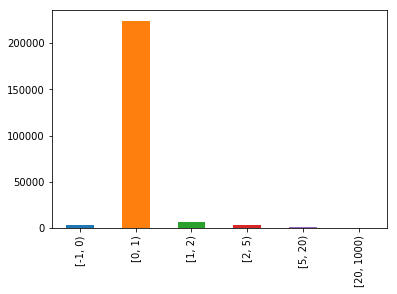

In [137]:
bins = [-1, 0, 1, 2, 5, 20, 1000]
pd.cut(pred_val, bins, right=False).value_counts().sort_index().plot.bar();

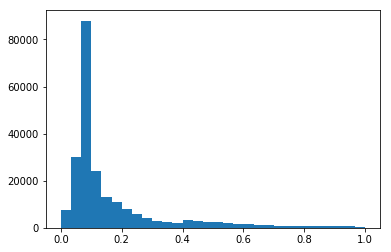

In [144]:
plt.hist(pred_val[(pred_val>=0) & (pred_val<1)], bins=30);

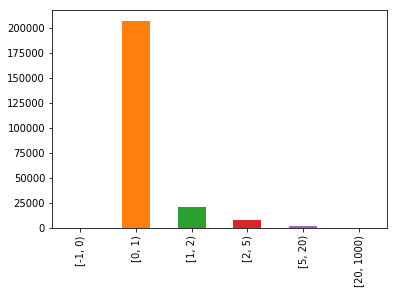

In [138]:
pd.cut(y_val, bins, right=False).value_counts().sort_index().plot.bar();

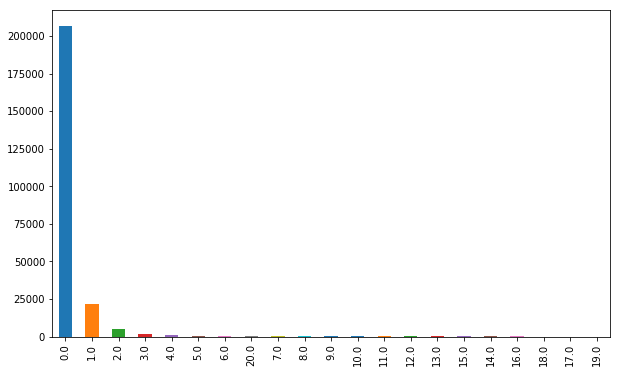

In [149]:
y_val.value_counts().plot.bar(figsize=(10,6));

In [22]:
err_train = pred_train - y_train
err_val = pred_val - y_val

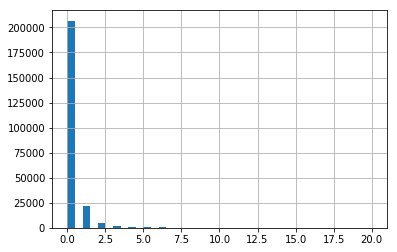

In [27]:
y_val.hist(bins=40)

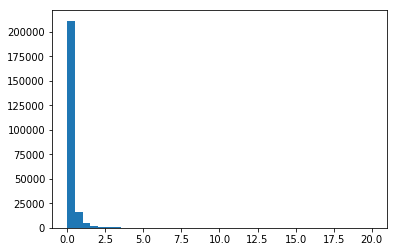

In [35]:
plt.hist(pred_val, bins=40);

In [28]:
y_val.describe()

count    238172.000000
mean          0.258565
std           1.136157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: target, dtype: float64

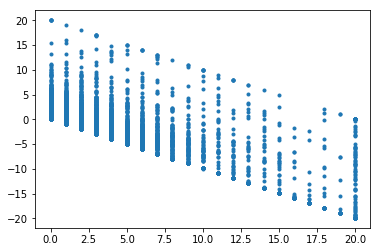

In [23]:
plt.plot(y_val, err_val, '.');

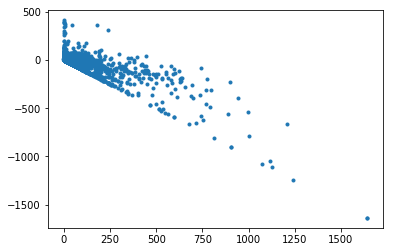

In [24]:
plt.plot(y_train, err_train, '.');

In [36]:
sum(y_val==0)/len(y_val)

0.8678644005172732

In [72]:
df_pred = pd.DataFrame({'y_val': y_val, 'pred_val': pred_val})

df_pred['target_zero'] = (df_pred['y_val']==0)
df_pred['pred_zero'] = (df_pred['pred_val']==0)

In [73]:
df_pred.sum()

y_val           61583.000000
pred_val        63135.032278
target_zero    206701.000000
pred_zero        3318.000000
dtype: float64

In [74]:
df_pred.head()

,y_val,pred_val,target_zero,pred_zero
10675678,1.0,0.083943,False,False
10675679,1.0,0.790752,False,False
10675680,2.0,0.895689,False,False
10675681,1.0,0.209757,False,False
10675682,1.0,0.599090,False,False


In [64]:
from sklearn.metrics import confusion_matrix, recall_score

In [75]:
confusion_matrix(df_pred['target_zero'], df_pred['pred_zero'])

array([[ 31186,    285],
       [203668,   3033]])

In [77]:
recall_score(df_pred['target_zero'], df_pred['pred_zero'])
# we are very bad at predicting zero at all, and in particular at predicting zero for targets equal to zero.

0.014673368779057673

In [81]:
df_pred.loc[df_pred['target_zero'], 'pred_val'].describe()

count    206701.000000
mean          0.176872
std           0.314790
min           0.000000
25%           0.070159
50%           0.085193
75%           0.166517
max          20.000000
Name: pred_val, dtype: float64

In [82]:
np.unique(y_val)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [ ]:
df_pred.loc[df_pred['']]

In [45]:
sum(pred_val[y_val==0]==0)

3033

In [39]:
y_val

10675678    1.0
10675679    1.0
10675680    2.0
10675681    1.0
10675682    1.0
10675683    3.0
10675684    1.0
10675685    2.0
10675686    1.0
10675687    1.0
10675688    1.0
10675689    1.0
10675690    1.0
10675691    1.0
10675692    1.0
10675693    1.0
10675694    1.0
10675695    1.0
10675696    1.0
10675697    1.0
10675698    2.0
10675699    2.0
10675700    1.0
10675701    4.0
10675702    1.0
10675703    1.0
10675704    1.0
10675705    1.0
10675706    1.0
10675707    1.0
           ... 
10913820    0.0
10913821    0.0
10913822    0.0
10913823    0.0
10913824    0.0
10913825    0.0
10913826    0.0
10913827    0.0
10913828    0.0
10913829    0.0
10913830    0.0
10913831    0.0
10913832    0.0
10913833    0.0
10913834    0.0
10913835    0.0
10913836    0.0
10913837    0.0
10913838    0.0
10913839    0.0
10913840    0.0
10913841    0.0
10913842    0.0
10913843    0.0
10913844    0.0
10913845    0.0
10913846    0.0
10913847    0.0
10913848    0.0
10913849    0.0
Name: target, Length: 23

In [ ]:
plt.scatter(y_train, err_train)

In [ ]:
plt.scatter(y_train, err_train)

In [73]:
model = Lasso(alpha=2)
X_train = X_train_oh
X_val = X_val_oh

udf.fit_eval_model(model, X_train, X_val, y_train, y_val)
pd.DataFrame({'features': X_train.columns,
              'coef': model.coef_}).append(
             {'features': 'intercept',
              'coef': model.intercept_},
             ignore_index=True)

Lasso
       R-squared   RMSE
train      0.397  2.743
val        0.193  1.020


,features,coef
0,date_block_num,0.000000e+00
1,item_id,-5.844343e-07
2,target_lag_1,2.754540e-01
3,target_item_lag_1,3.392188e-03
4,target_shop_lag_1,4.735232e-05
5,target_lag_2,2.112424e-02
6,target_item_lag_2,8.034785e-04
7,target_shop_lag_2,-5.476311e-06
8,target_lag_3,1.864067e-02
9,target_item_lag_3,2.001532e-03


### LR on log-transformed numerical features

In [21]:
# fit model on transformed sales data
model = LinearRegression()
model.fit(X_train_trans, y_train_trans)

# predict model on transformed scale
pred_train_trans = model.predict(X_train_trans)
pred_val_trans = model.predict(X_val_trans)

# transform predictions to original scale
pred_train = udf.inv_log_transform(pred_train_trans, y_train_min)
pred_val = udf.inv_log_transform(pred_val_trans, y_train_min)

# clip predictions on original scale
pred_val = np.clip(pred_val, 0, 20)

# Evaluate predictions
rsquared = [r2_score(y_train, pred_train), r2_score(y_val, pred_val)]
rmse = [np.sqrt(mean_squared_error(y_train, pred_train)), np.sqrt(mean_squared_error(y_val, pred_val))]

pd.DataFrame({'R-squared': np.round(rsquared, 3), 'RMSE': np.round(rmse, 3)},
                  index=['train', 'val'])

,R-squared,RMSE
train,-0.007,3.543
val,-0.044,1.161


### LR on winsorized numerical features

In [52]:
lr = LinearRegression()  
udf.fit_eval_model(lr, X_train_wins, X_val_wins, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.245  3.069
val        0.139  1.054


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### LR on scaled features

In [72]:
# standardized lagged sales features
lr = LinearRegression()  
udf.fit_eval_model(lr, X_train_std, X_val_std, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.470  2.570
val        0.212  1.009


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
# standardized linear regression coefficients:
pd.DataFrame({'features': X_train_std.columns, 'coef': lr.coef_}).append({'features': 'intercept', 'coef': lr.intercept_}, ignore_index=True)

,features,coef
0,date_block_num,-0.000175
1,target_lag_1,1.266130
2,target_item_lag_1,0.176797
3,target_shop_lag_1,0.119876
4,target_lag_2,0.295771
5,target_item_lag_2,-0.055737
6,target_shop_lag_2,-0.049679
7,target_lag_3,0.305168
8,target_item_lag_3,0.063550
9,target_shop_lag_3,-0.035826


In [78]:
X_train_std[target_lags + shop_lags + item_lags].max()

target_lag_1          370.482347
target_lag_2          383.467531
target_lag_3          376.526817
target_lag_6          366.303326
target_lag_12         409.121527
target_shop_lag_1       7.833245
target_shop_lag_2       7.714899
target_shop_lag_3       7.673416
target_shop_lag_6       7.547444
target_shop_lag_12      7.917369
target_item_lag_1     124.464285
target_item_lag_2     122.557040
target_item_lag_3     119.854278
target_item_lag_6     113.617597
target_item_lag_12    125.146659
dtype: float64

In [70]:
# normalizing all features
lr = LinearRegression(normalize=True)  
udf.fit_eval_model(lr, X_train_num, X_val_num, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.470  2.570
val        0.212  1.009


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### New numerical features and hand-selection

In [118]:
lr = LinearRegression(normalize=True)  
udf.fit_eval_model(lr, X_train_sel, X_val_sel, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.458  2.599
val        0.215  1.006


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [112]:
# standardized linear regression coefficients:
pd.DataFrame({'features': X_train_sel.columns, 'coef': lr.coef_}).append({'features': 'intercept', 'coef': lr.intercept_}, ignore_index=True)

,features,coef
0,date_block_num,1.795753e-04
1,target_lag_1,-3.356155e+08
2,target_item_lag_1,1.781720e-03
3,target_shop_lag_1,4.487324e-05
4,target_lag_2,-3.356155e+08
5,target_item_lag_2,-6.772389e-04
6,target_shop_lag_2,-1.905105e-05
7,target_lag_3,-3.356155e+08
8,target_item_lag_3,5.627330e-04
9,target_shop_lag_3,-1.116915e-05


In [87]:
lr = LinearRegression(normalize=True)  
udf.fit_eval_model(lr, X_train_sel, X_val_sel, y_train, y_val)

LinearRegression
       R-squared   RMSE
train      0.458  2.600
val        0.216  1.006


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

## Re-train and make submission

In [17]:
all_train, all_test = train_data, val_data = grid.train_test_split_by_month(all_sales, 34)

Train data: date_block_num 12 to 33
Test data: date_block_num 34
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/Build_data_grid.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


In [18]:
lr = LinearRegression()

lr.fit(all_train[lag_cols], all_train['target'])
pred_test = lr.predict(all_test[lag_cols].values)

# truncate predictions to [0, 20] as for test data
pred_test = np.clip(pred_test, 0, 20)

In [19]:
pred_submit = all_test[['item_id', 'shop_id']].copy()
pred_submit['target'] = pred_test

In [20]:
pred_submit.shape

(214200, 3)

In [ ]:
# create submission file with IDs from test data
submit = (pd.merge(test_data, pred_submit, how='left', on=['shop_id', 'item_id'])
              .rename(columns={'target': 'item_cnt_month'})
                  .drop(columns=['shop_id', 'item_id'])
          )

In [ ]:
submit.shape

In [ ]:
# submit.to_csv('submission_linreg_monthly_lagged_sales.csv', index=False)
# yields public leaderboard score of 1.08009

## Adding shop and item static information
After computing the lags, add in additional information on shops and items, after computing the lagged sales data for more efficient computation. 

In [2]:
items_data = udf.merge_items_data()
shops_data = udf.clean_shops_data()

In [25]:
item_cols = ['item_id', 'item_category_id', 'item_category_group']
shop_cols = ['shop_id', 'shop_city']

all_data = (all_sales.merge(items_data[item_cols], how='left', on='item_id')
                .merge(shops_data[shop_cols], how='left', on='shop_id')
               )

In [ ]:
all_data.info()

In [27]:
train_data, val_data = grid.train_test_split_by_month(all_data, 33)

Train data: date_block_num 12 to 32
Test data: date_block_num 33
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/Build_data_grid.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


In [29]:
train_data.dtypes

date_block_num            int64
item_id                   int64
shop_id                   int64
target                  float64
target_item             float64
target_shop             float64
target_lag_1              int64
target_item_lag_1         int64
target_shop_lag_1         int64
target_lag_2              int64
target_item_lag_2         int64
target_shop_lag_2         int64
target_lag_3              int64
target_item_lag_3         int64
target_shop_lag_3         int64
target_lag_4              int64
target_item_lag_4         int64
target_shop_lag_4         int64
target_lag_5              int64
target_item_lag_5         int64
target_shop_lag_5         int64
target_lag_12             int64
target_item_lag_12        int64
target_shop_lag_12        int64
item_category_id          int64
item_category_group    category
shop_city              category
dtype: object

In [38]:
X_train.shape

(6186922, 20)

In [39]:
# increase regularization
features = lag_cols + ['item_id', 'shop_id', 'item_category_id']
X_train, y_train = train_data[features], train_data['target']
X_val, y_val = val_data[features], val_data['target']

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**8, 
               'bagging_fraction': 0.6, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
# truncate predictions
pred_val = np.clip(pred_val, 0, 20)

print('in sample R-squared:', r2_score(y_train, pred_train))
print('in sample RMSE:', np.sqrt(mean_squared_error(y_train, pred_train)))
print('val set R-squared:', r2_score(y_val, pred_val))
print('val set  RMSE:', np.sqrt(mean_squared_error(y_val, pred_val)))

in sample R-squared: 0.4229816294327552
in sample RMSE: 2.682711639932309
val set R-squared: 0.2000043088920217
val set  RMSE: 1.016204995494643


In [31]:
features = lag_cols + ['item_id', 'shop_id', 'item_category_id']
X_train, y_train = train_data[features], train_data['target']
X_val, y_val = val_data[features], val_data['target']

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
# truncate predictions
pred_val = np.clip(pred_val, 0, 20)

print('in sample R-squared:', r2_score(y_train, pred_train))
print('in sample RMSE:', np.sqrt(mean_squared_error(y_train, pred_train)))
print('val set R-squared:', r2_score(y_val, pred_val))
print('val set  RMSE:', np.sqrt(mean_squared_error(y_val, pred_val)))

in sample R-squared: 0.5054331141392824
in sample RMSE: 2.483657414388694
val set R-squared: 0.08951233577745954
val set  RMSE: 1.0841129560797282


Observations from trying different models:
- lightGBM performs worse when including item and shop and category ids, both in terms of speed and predictive power. it overfits a lot. try increasing regularization parameters!


In [32]:
train_data['item_id'].nunique()

16561

In [33]:
train_data['shop_id'].nunique()

54

In [34]:
train_data['item_category_id'].nunique()

79

In [37]:
features = lag_cols + ['shop_id', 'item_category_id']
X_train, y_train = train_data[features], train_data['target']
X_val, y_val = val_data[features], val_data['target']

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
# truncate predictions
pred_val = np.clip(pred_val, 0, 20)

print('in sample R-squared:', r2_score(y_train, pred_train))
print('in sample RMSE:', np.sqrt(mean_squared_error(y_train, pred_train)))
print('val set R-squared:', r2_score(y_val, pred_val))
print('val set  RMSE:', np.sqrt(mean_squared_error(y_val, pred_val)))

in sample R-squared: 0.4941174925636759
in sample RMSE: 2.5119095949630457
val set R-squared: 0.2860374065293274
val set  RMSE: 0.9600088370415591


In [ ]:
cat_cols = ['item_id', 'shop_id', 'item_category_id']

In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 27 columns):
date_block_num         int64
item_id                int64
shop_id                int64
target                 float64
target_item            float64
target_shop            float64
target_lag_1           int64
target_item_lag_1      int64
target_shop_lag_1      int64
target_lag_2           int64
target_item_lag_2      int64
target_shop_lag_2      int64
target_lag_3           int64
target_item_lag_3      int64
target_shop_lag_3      int64
target_lag_4           int64
target_item_lag_4      int64
target_shop_lag_4      int64
target_lag_5           int64
target_item_lag_5      int64
target_shop_lag_5      int64
target_lag_12          int64
target_item_lag_12     int64
target_shop_lag_12     int64
item_category_id       int64
item_category_group    category
shop_city              category
dtypes: category(2), float64(3), int64(22)
memory usage: 1.3 GB


In [ ]:
lgb.Dataset()

In [1]:
data_nontree = all_sales.copy()

NameError: name 'all_sales' is not defined

In [ ]:
shop_dummies = pd.get_dummies(data_nontree['shop_id'].astype('category'), prefix='shop_id', drop_first=True, dtype=int)
shop_cols = list(shop_dummies.columns)

data_nontree = pd.concat([data_nontree, shop_dummies], axis=1)

del shop_dummies
gc.collect()

In [ ]:
data_nontree = grid.downcast_dtypes(data_nontree)

In [10]:
train_data, val_data = grid.train_test_split_by_month(all_sales, 33)

Train data: date_block_num 12 to 32
Test data: date_block_num 33
target values in test data are clipped to [0, 20]


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/Build_data_grid.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)
